In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft

def dBmag(x):
    return 20*np.log10(np.abs(x))

def diffmod(x):
    d = (x[2:] - x[:-2] + np.pi) % (2*np.pi) - np.pi
    return np.r_[0, d / 2, 0]

def round2(x, bits=7, truncate=True):
    if x.dtype == np.complex:
        return round2(np.real(x), bits, truncate) + 1.j * round2(np.imag(x), bits, truncate)
    if truncate:
        return x - x % 2**(-bits)
    else:
        return np.round(x * 2**bits) * 2**(-bits)

In [2]:
f_samp = 48000 * 5 * 5
print(f_samp)
dynrange = dBmag(128)
t = np.linspace(0, 1, f_samp, endpoint=False)
dt = 1 / f_samp

1200000


$m(t) = \exp( 2\pi i f_{d} \int_0^t s(t) dt)$

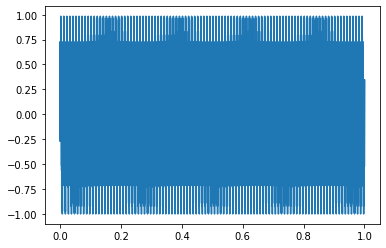

In [3]:
f_dev = 5000
source = np.sin(100*2*np.pi*t) + 0.4 * np.sin(500*2*np.pi*t) + np.sin(3000*2*np.pi*t + 1)
source -= np.mean(source)
source /= np.max(np.abs(source))
modulated = np.exp(2.j * np.pi * f_dev * (dt * np.cumsum(source)))
plt.plot(t, source)

$u(t) = exp(2\pi i f_{c} t) m(t)$

In [4]:
carrier = 120000.
upconverted = np.exp(2.j * np.pi * carrier * t) * modulated

In [5]:
noise = (np.random.normal(scale=.002, size=2*upconverted.size).reshape(-1, 2) * [1, 1.j]).sum(axis=1)
received = round2(upconverted + noise)

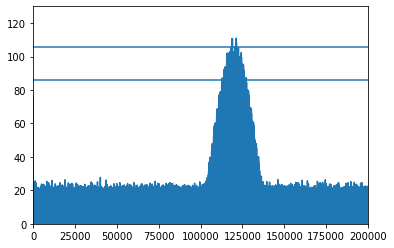

In [6]:
plt.plot(dBmag(fft(received)))
plt.gca().set_xlim(0, 200000)
plt.gca().set_ylim(0, 130)
plt.gca().axhline(86)
plt.gca().axhline(106)

In [7]:
f_downconvert = carrier * 1.0
downconverted = np.exp(-2.j * np.pi * f_downconvert * t)
downconverted = round2(round2(downconverted, bits=7) * received)

In [8]:
(f_dev * 4 / (f_samp/2))**.5

0.18257418583505536

rounding to 9.0


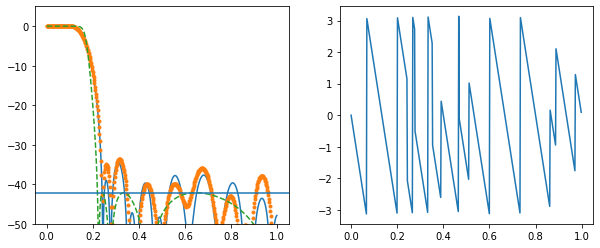

In [9]:
num, den = signal.cheby2(7, dBmag(128), 0.22)
pts = np.linspace(0, 1, 1024)
f, h = signal.freqz(num, den, pts, fs=2)

num = signal.firwin2(31, f, np.abs(h), window=('kaiser', 2))
den = 1.

f2, h2 = signal.freqz(num, den, fs=2)

nbits = np.ceil(-np.log2(abs(num[num!=0]).min()))
print("rounding to", nbits)
num = round2(num, bits=nbits, truncate=False)
_, hr = signal.freqz(num, den, fs=2)


fig, (mag, phase) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
mag.plot(f2, dBmag(h2))
mag.plot(f2, dBmag(hr), '.')
mag.plot(f, dBmag(h), '--')
mag.axhline(-dynrange)
mag.set_ylim(-50, 5)
# mag.set_xlim(0, 0.5)
phase.plot(f2, np.angle(h2))
# phase.set_xlim(0, 0.3)

In [10]:
(num * 2**nbits).astype(int)

array([  3,   4,   5,   3,  -1,  -7, -12, -15, -13,  -4,  10,  30,  52,
        71,  85,  93,  85,  71,  52,  30,  10,  -4, -13, -15, -12,  -7,
        -1,   3,   5,   4,   3])

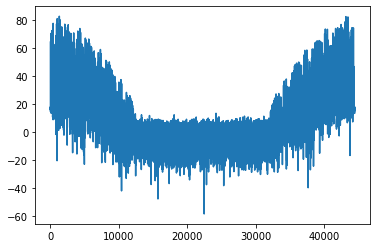

In [11]:
div = 3
downsampled = round2(signal.lfilter(num, den, downconverted)[::div])
downsampled = round2(signal.lfilter(num, den, downsampled)[::div])
downsampled = round2(signal.lfilter(num, den, downsampled)[::div])
dsamp = div**3
f_recv = f_samp / dsamp

plt.plot(dBmag(fft(downsampled)))

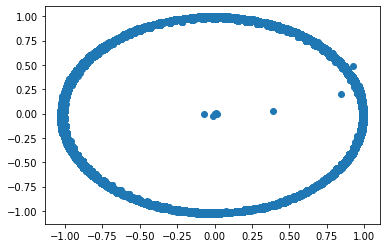

In [12]:
i, q = np.real(downsampled), np.imag(downsampled)
plt.scatter(i, q)

$\frac{dm(t)}{dt} =  2\pi i f_{d} s(t) m(t)$

In [13]:
def lowdiff(K, taps):
    """Low-pass differentiator
    
    From http://eeweb.poly.edu/iselesni/lowdiff/lowdiff.pdf
    """
    if taps % 2 != K % 2:
        raise ValueError
    L = (taps - K)//2 - 1
    c = np.zeros(L + 1)
    c[0] = 2
    c[1] = K + 1/3
    for n in range(2, L + 1):
        # eqn. 60
        c[n] = ((-K + 4*K*n - 10*n + 3 + 8*n**2)*c[n-1] - (2*n + K - 3)**2 * c[n-2])/(2*n*(2*n+1))
    
    # eqn. 58 by convolutions (from matlab script)
    q = 1
    h = c[0]
    for n in range(1, L + 1):
        q = np.convolve(q, [-0.25, 0.5, -0.25])
        h = np.r_[0, h, 0] + c[n] * q

    for _ in range(K):
        h = np.convolve(h, [0.5, 0.5])
    
    h = np.convolve(h, [0.5, -0.5])
    return h

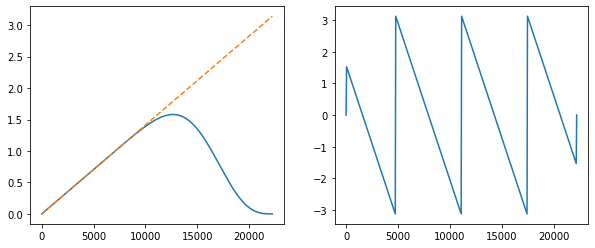

In [14]:
num = lowdiff(3, 15)
den = 1.

f, h = signal.freqz(num, den, np.linspace(0, 1, 512), fs=2)
fig, (mag, phase) = plt.subplots(1, 2, figsize=(10, 4))
mag.plot(f * f_recv/2, np.abs(h))
mag.plot(f * f_recv/2, np.pi * f, '--')
phase.plot(f * f_recv/2, np.angle(h))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


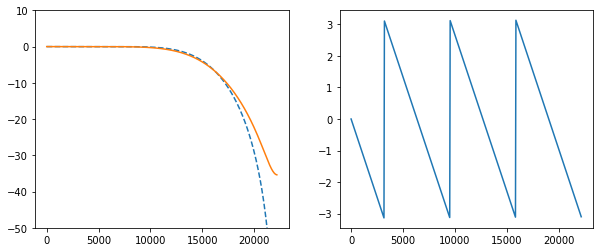

In [15]:
hh = np.abs(h) / (np.pi * f)
hh[0] = 1.
num2 = signal.firwin2(len(num), f, hh, window=('kaiser', 3), fs=2)
den2 = 1.

f2, h2 = signal.freqz(num2, den2, fs=2)
fig, (mag, phase) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
mag.plot(f * f_recv/2, dBmag(hh), '--')
mag.plot(f2 * f_recv/2, dBmag(h2))
mag.set_ylim(-50, 10)
phase.plot(f2 * f_recv/2, np.angle(h2))
# phase.set_xlim(0, 0.3)

In [16]:
nbits_diff = np.ceil(-np.log2(abs(num[num!=0]).min()))
nbits_delay = np.ceil(-np.log2(abs(num2[num2!=0]).min()))
print(f"differentiator {nbits_diff}, delay {nbits_delay}")

scale = f_recv / (2. * np.pi * f_dev)
print("derivative scale factor", scale)

num = round2(num * np.sqrt(scale), nbits_diff, truncate=False)
num2 = round2(num2 * np.sqrt(scale), nbits_delay, truncate=False)

print(f"diff taps:", repr((num*2**nbits_diff).astype(int)))
print(f"delay taps:", repr((num2*2**nbits_delay).astype(int)))

differentiator 12.0, delay 12.0
derivative scale factor 1.4147106052612919
diff taps: array([   -2,    24,  -120,   338,  -489,  -137,  3300,     0, -3300,
         137,   489,  -338,   120,   -24,     2])
delay taps: array([  -2,    8,  -25,   28,  106, -528, 1117, 3462, 1117, -528,  106,
         28,  -25,    8,   -2])


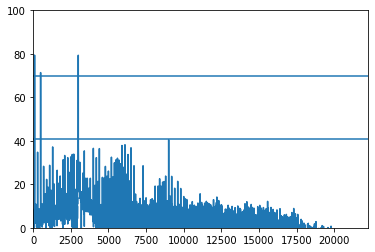

In [17]:
if True:
    delay = (len(num) - 1) // 2
    if True:
        id = signal.lfilter(num2, den2, i)
        qd = signal.lfilter(num2, den2, q)
    else:
        id = np.r_[np.zeros(delay), i[:-delay]]
        qd = np.r_[np.zeros(delay), q[:-delay]]
    ip = signal.lfilter(num, den, i)
    qp = signal.lfilter(num, den, q)
else:
    delay = 0
    id = i
    ip = np.convolve(i, [0.5, 0, -0.5], 'same')
    qd = q
    qp = np.convolve(q, [0.5, 0, -0.5], 'same')
    
dphi = round2(id * qp - qd * ip, 22)
plt.plot(dBmag(fft(dphi)))
plt.gca().set_xlim(0, f_recv / 2)
plt.gca().set_ylim(0, 100)
plt.gca().axhline(41)
plt.gca().axhline(70)

(0.0, 0.01)

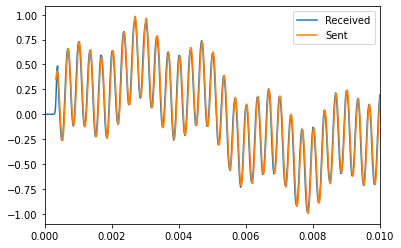

In [18]:
plt.plot(t[::dsamp], dphi, label='Received')
plt.plot(t[::dsamp] + 400 / f_samp, source[::dsamp], label='Sent')

plt.gca().legend()
plt.gca().set_xlim(0., .01)

In [19]:
print(f_downconvert, np.mean(dphi) * 2 * np.pi)

120000.0 9.920855913685379e-05


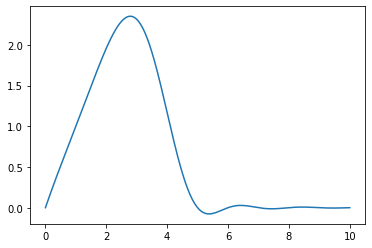

In [20]:
# http://eeweb.poly.edu/iselesni/lowdiff/lowdiff.pdf
freqs = np.linspace(0, 10, 512)
K = 4
ak = np.array([0.9999, 1.9591, 2.3145, 1.1673])[None, :]
k = np.arange(K)[None, :] + 1
a = np.sum(ak * np.sinc(freqs[:, None] - k) - np.sinc(freqs[:, None] + k), axis=1)

plt.plot(freqs, a)

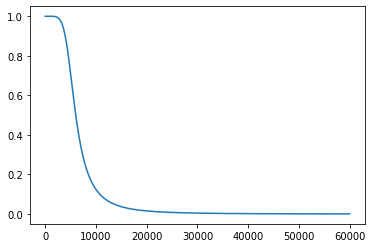

In [21]:
# IIR butterworth
warp = lambda f: 2 * np.tan(f / 2)
num, den = signal.butter(3, warp(f_dev * 2 * np.pi / f_samp), analog=True)
# num = np.r_[num, 0.]
num, den = signal.bilinear(num, den)
f, h = signal.freqz(num, den, np.linspace(0, 0.1 * np.pi, 1000))

plt.plot(f_samp * f / np.pi / 2, np.abs(h))

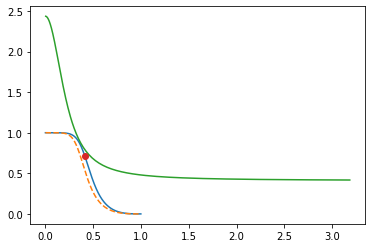

In [22]:
num, den = signal.bilinear(*signal.butter(3, warp(1.3), analog=True))
f, h = signal.freqz(num, den)
plt.plot(f / np.pi, np.abs(h))

num, den = signal.bilinear(*signal.butter(3, 1.3, analog=True))
f, h = signal.freqz(num, den)
plt.plot(f / np.pi, np.abs(h), '--')

num, den = signal.butter(5, 1.3 / np.pi, analog=False, fs=1.)
f, h = signal.freqs(num, den)
plt.plot(f / np.pi, np.abs(h))

plt.plot(1.3 / np.pi, 10**(-3/20), 'o')
